# Dispersion example

In this eight lab of the ErSE 210 - Seismology course, we will learn how to work with Surface waves. 

More precisely, this notebook is divided into 3 parts: 

- Model dispersion curves from a parametrized layered medium using the great [disba](https://github.com/keurfonluu/disba) library. In this lab, we will focus primarely on Rayleigh waves even though a similar flow can be applied to Love-waves too;
- Model synthetic, surface-wave only seismic shot gathers by frequency-dependant shifting of a user-defined source wavelet;
- Dispersion panel creation and picking;
- Nonlinear inversion of surface wave dispersion curves for layered media parameters.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pylops

from functools import partial
from scipy.optimize import minimize, Bounds
from disba import PhaseDispersion

from surfacewaves import *
from dispersionspectra import *
from inversion import *

## Dispersion curve modelling

Let's start by learning how we can compute the Rayleigh-wave wave dispersion curve from a parametrized layered medium, where each layer is defined by the following 4 parameters: $(\Delta z, v_p, v_s, \rho)$.

In theory, under the assumption of a layered medium, the elastic wave equation can be turned ino an eigenvalue problem whose solution is the surface wave dispersion curve. This is referred in the literature as Dunkin's matrix algorithm as explained in more details in class.

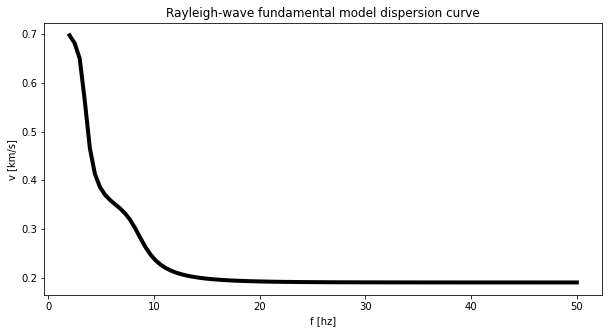

In [2]:
# Define model as:
# thickness, Vp, Vs, density
# km, km/s, km/s, g/cm3
thick = np.array([0.01, 0.04, 0.01])
vs = np.array([0.2, 0.4, 0.8])
true_model = np.vstack([thick, vs*4, vs, np.ones(3)]).T

# Frequency axis
fdisp = np.linspace(2, 50, 101)

# Periods (must be sorted starting with low periods)
period = np.flipud(1/fdisp)

# Rayleigh-wave fundamental model dispersion curve 
pd = PhaseDispersion(*true_model.T)
cpr = pd(period, mode=0, wave="rayleigh") 
vdisp = np.flipud(cpr[1]) # flip it back to show it as function of f instead of period

plt.figure(figsize=(10, 5))
plt.plot(fdisp, vdisp, 'k', lw=4)
plt.xlabel('f [hz]')
plt.ylabel('v [km/s]')
plt.title('Rayleigh-wave fundamental model dispersion curve');

## Synthetic seismogram

Next, we will be using the dispersion relation to create a surface-wave only seismic shot gather. This is of course a highly simplified version of what you would obtain by using the full elastic wave equation; nevertheless, it serves as a good basis to test algorithms used to create dispersion spectra as it does not contain any interference from other modes and other types of waves (e.g., direct arrival, reflections..).

The modelling is performed in the frequency domain as follows:

$$
d(f,x) = s(f) e^{j 2 \pi f x/v(f)}
$$

where $s(f)$ is the frequency spectrum of the source wavelet.

In [3]:
# Axes
nt = 600 # number of time samples
dt = 0.008 # time sampling in s
nx = 201 # number of spatial samples
dx = 2 # spatial sampling in m
nfft = 2**10

t, x = np.arange(nt)*dt, np.arange(nx)*dx

# Wavelet
wav = ormsby(t[:nt//2+1], f=[2, 4, 38, 40], taper=np.hanning)[0][:-1]
wav = np.roll(np.fft.ifftshift(wav), 20) # apply small shift to make it causal

dshift, f, vf = surfacewavedata(nt, dt, nx, dx, nfft, fdisp, vdisp, wav)

## Dispersion panel

Let's move on to create dispersion panels. This is a transformation of the previously computed shot gather in a domain where the dispersion curve could be extracted from data. In short, it can be seen as a FK transform stretched over the K axis.

In practice, different approaches exist to compute dispersion panels and here we will be using the famous Park method, which implements the following equation:

$$
W(\omega, c)=\int_{-\infty}^{+\infty} e^{-i\left(\frac{\omega}{c}\right) x} \frac{D(x, \omega)}{|D(x, \omega)|} d x
$$

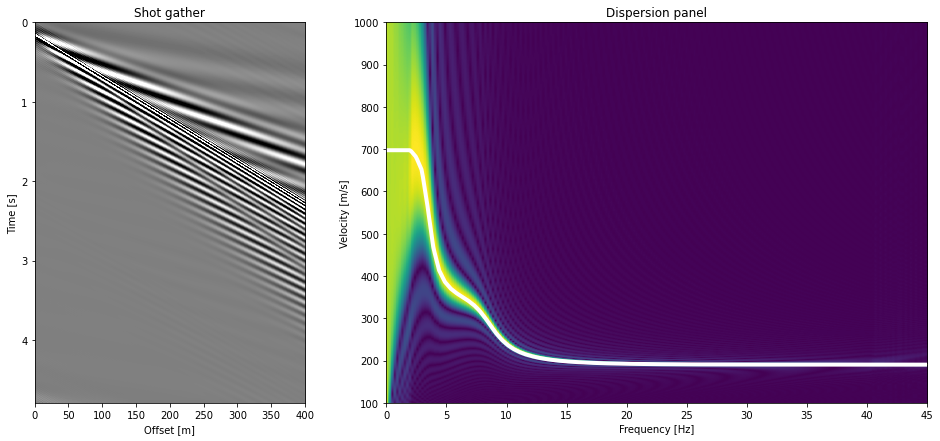

In [4]:
# Convert from f-kx to f-velocity (with function)
nvel = 401
vlims = (100, 1000)
vdispsp = np.linspace(vlims[0], vlims[1], nvel)
Ddispsp = parkdispersion(dshift, dx, dt, vdispsp[0], vdispsp[-1], vdispsp[1]-vdispsp[0], f[-1])[2]

fig, axs = plt.subplots(1, 2, figsize=(16, 7), gridspec_kw={'width_ratios': [1, 2]})
axs[0].imshow(dshift.T, cmap='gray', vmin=-.1, vmax=.1, extent=[x[0], x[-1], t[-1], t[0]])
axs[0].axis('tight')
axs[0].set_xlabel('Offset [m]')
axs[0].set_ylabel('Time [s]')
axs[0].set_title('Shot gather')
axs[1].imshow(Ddispsp, origin='lower', extent=(f[0], f[-1], vdispsp[0], vdispsp[-1]))
axs[1].plot(f, vf*1e3, 'w', lw=4)
axs[1].axis('tight')
axs[1].set_xlim(0, 45)
axs[1].set_ylabel('Velocity [m/s]')
axs[1].set_xlabel('Frequency [Hz]')
axs[1].set_title('Dispersion panel');

## Inversion

Finally we write a simple deterministic inversion algorithm to estimate thicknesses and shear wave velocities $(\Delta z, v_s)$ from the dispersion curve of the fundamental mode. In this case, we assume a known relationship between $v_p$ and $v_s$ and constant density $rho$. We also assume that the number of layers is known a priori.

Here, we simply leverage scipy's `scipy.optimize.minimize` method. From a user perspective, we are simply required to write a function that takes all the inputs (here all thicknesses and shear wave velocities for the different layers) and returns a measure of distance (or misfit) between the true and predicted dispersion curve.

In [5]:
# Exact solution
nlayers = 3
thick0 = true_model[:, 0]
vs0 = true_model[:, 2]
    
x0 = np.hstack([thick0, vs0])
fun(x0.ravel(), nlayers=nlayers, t=period, vdispobs=np.flipud(vdisp))

0.0

In [6]:
# Initial solution
nlayers = 3
thick0 = np.array([0.02, 0.02, 0.02])
vs0 = np.array([0.2, 0.6, 0.6])

x0 = np.hstack([thick0, vs0])
fun(x0.ravel(), nlayers=nlayers, t=period, vdispobs=np.flipud(vdisp))

0.47227213178762795

In [7]:
# Inversion
nlayers = 3
thick0 = np.array([0.02, 0.02, 0.02])
vs0 = np.array([0.2, 0.6, 0.6])
    
x0 = np.hstack([thick0, vs0])
bd = Bounds(lb=np.zeros(nlayers*2), ub=np.inf * np.ones(nlayers*2), keep_feasible=False)
nl = minimize(fun, x0.ravel(), args=(nlayers, period, np.flipud(vdisp)), bounds=bd,
              method='Nelder-Mead', options=dict(maxiter=1000))
thickest = nl.x[:nlayers]
vsest = nl.x[nlayers:]

print('Thickness', thick, thick0, thickest)
print('VS', vs, vs0, vsest)

Thickness [0.01 0.04 0.01] [0.02 0.02 0.02] [0.00999879 0.04000142 0.03551139]
VS [0.2 0.4 0.8] [0.2 0.6 0.6] [0.19999153 0.39998676 0.79999018]


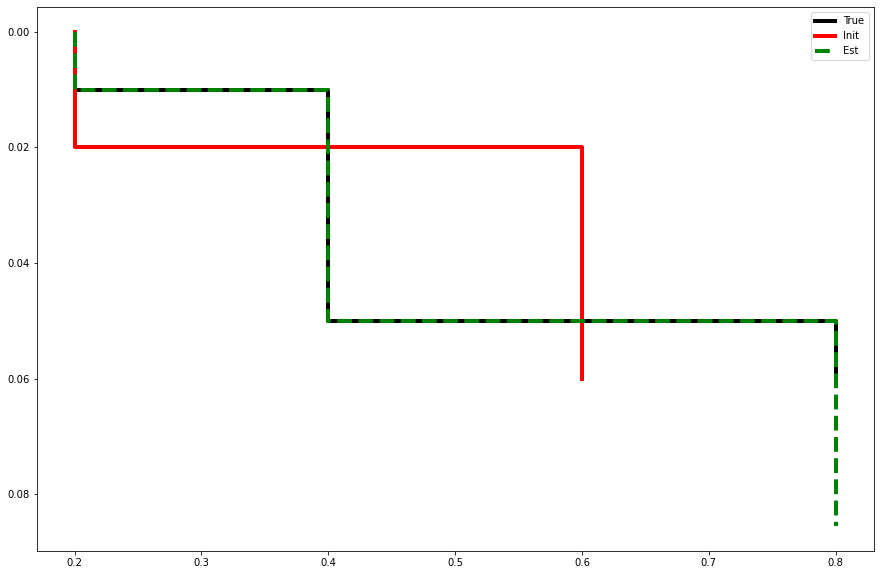

In [8]:
thickplt = np.insert(thick, 0, 0)
vsplt = np.insert(vs, -1, vs[-1])
thick0plt = np.insert(thick0, 0, 0)
vs0plt = np.insert(vs0, -1, vs0[-1])
thickestplt = np.insert(thickest, 0, 0)
vsestplt = np.insert(vsest, -1, vsest[-1])

plt.figure(figsize=(15, 10))
plt.step(vsplt, np.cumsum(thickplt), 'k', lw=4, label='True')
plt.step(vs0plt, np.cumsum(thick0plt), 'r', lw=4, label='Init')
plt.step(vsestplt, np.cumsum(thickestplt), '--g', lw=4, label='Est')
plt.gca().invert_yaxis()
plt.legend();

## Multi-mode data

Finally we repeat the modelling part of this notebook using in this case multiple modes (fundamental, 1st, and 2nd).

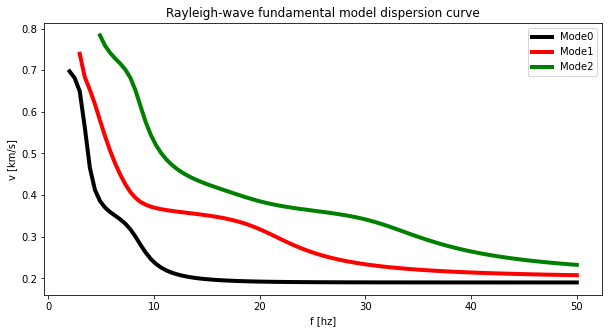

In [9]:
# Rayleigh-wave fundamental model dispersion curve 
pd = PhaseDispersion(*true_model.T)
cpr = [pd(period, mode=imode, wave="rayleigh") for imode in range(3)]

color = ['k', 'r', 'g']
plt.figure(figsize=(10, 5))
for imode in range(3):
    plt.plot(np.flipud(1/cpr[imode][0]), np.flipud(cpr[imode][1]), color[imode], lw=4, label=f'Mode{imode}')
plt.legend()
plt.xlabel('f [hz]')
plt.ylabel('v [km/s]')
plt.title('Rayleigh-wave fundamental model dispersion curve');

In [10]:
# Data
dshifts, fs, vfs = [], [], []
for imode in range(3):
    dshift_, f_, vf_ = surfacewavedata(nt, dt, nx, dx, nfft, np.flipud(1/cpr[imode][0]), np.flipud(cpr[imode][1]), wav)
    dshifts.append(dshift_[np.newaxis])
    fs.append(f_)
    vfs.append(vf_)
dshift = np.concatenate(dshifts).sum(0)

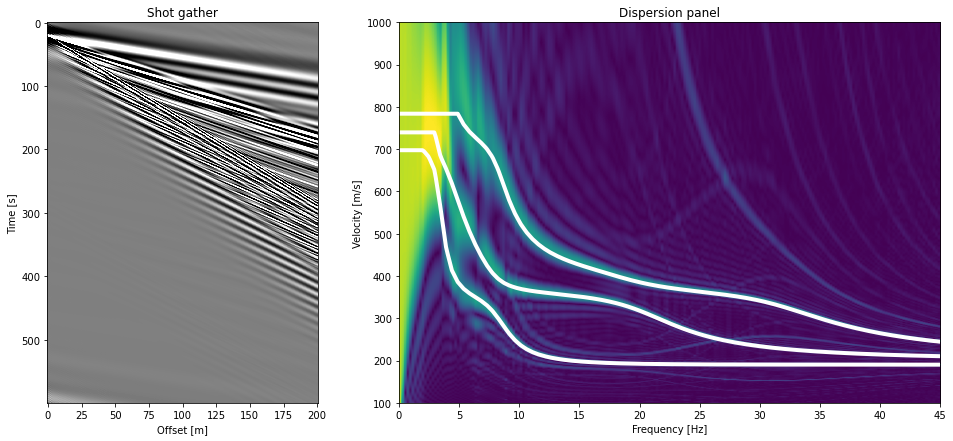

In [11]:
# Convert from f-kx to f-velocity (with function)
nvel = 401
vlims = (100, 1000)
vdispsp = np.linspace(vlims[0], vlims[1], nvel)
Ddispsp = parkdispersion(dshift, dx, dt, vdispsp[0], vdispsp[-1], vdispsp[1]-vdispsp[0], f[-1])[2]

fig, axs = plt.subplots(1, 2, figsize=(16, 7), gridspec_kw={'width_ratios': [1, 2]})
axs[0].imshow(dshift.T, cmap='gray', vmin=-.1, vmax=.1)
axs[0].axis('tight')
axs[0].set_xlabel('Offset [m]')
axs[0].set_ylabel('Time [s]')
axs[0].set_title('Shot gather')
axs[1].imshow(Ddispsp, origin='lower', extent=(f[0], f[-1], vdispsp[0], vdispsp[-1]))
for imode in range(3):
    axs[1].plot(fs[imode], vfs[imode]*1e3, 'w', lw=4)
axs[1].axis('tight')
axs[1].set_xlim(0, 45)
axs[1].set_ylabel('Velocity [m/s]')
axs[1].set_xlabel('Frequency [Hz]')
axs[1].set_title('Dispersion panel');

## Additional tasks:

- Write basic picker for dispersion panels (e.g., just argmax of each freq trace) and compare inversion with true one
- Write basic particle swarm with [PySwarms](http://pyswarms.readthedocs.io) or any other probabilistic inversion (e.g., [pyMC3](https://www.pymc.io/projects/docs/en/v3/index.html)) 